In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.interpolate import interp1d

不使用滤波器生成目标功率谱密度噪声测试

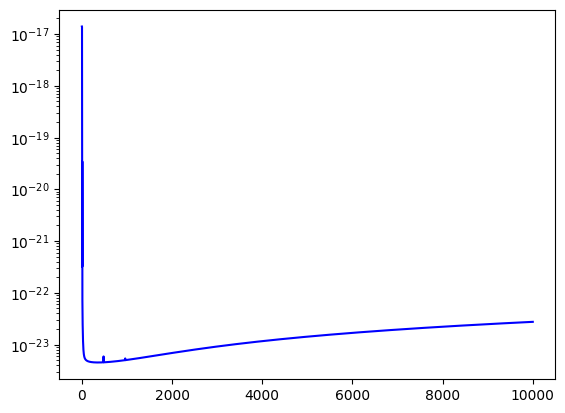

In [4]:

# 获取频率和噪声功率谱密度
freq_psd = np.loadtxt('aligo_design.txt')

freqs_ligo = freq_psd[:,0]
psd_ligo = freq_psd[:,1]
freqs_ligo[0] = 0

PSD_ligo_map =interp1d(freqs_ligo,psd_ligo)

fig = plt.figure()
plt.plot(freqs_ligo, psd_ligo, 'b')
plt.yscale('log')
plt.show()

/home/ywq/anaconda3/envs/pycbc1.14.1/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


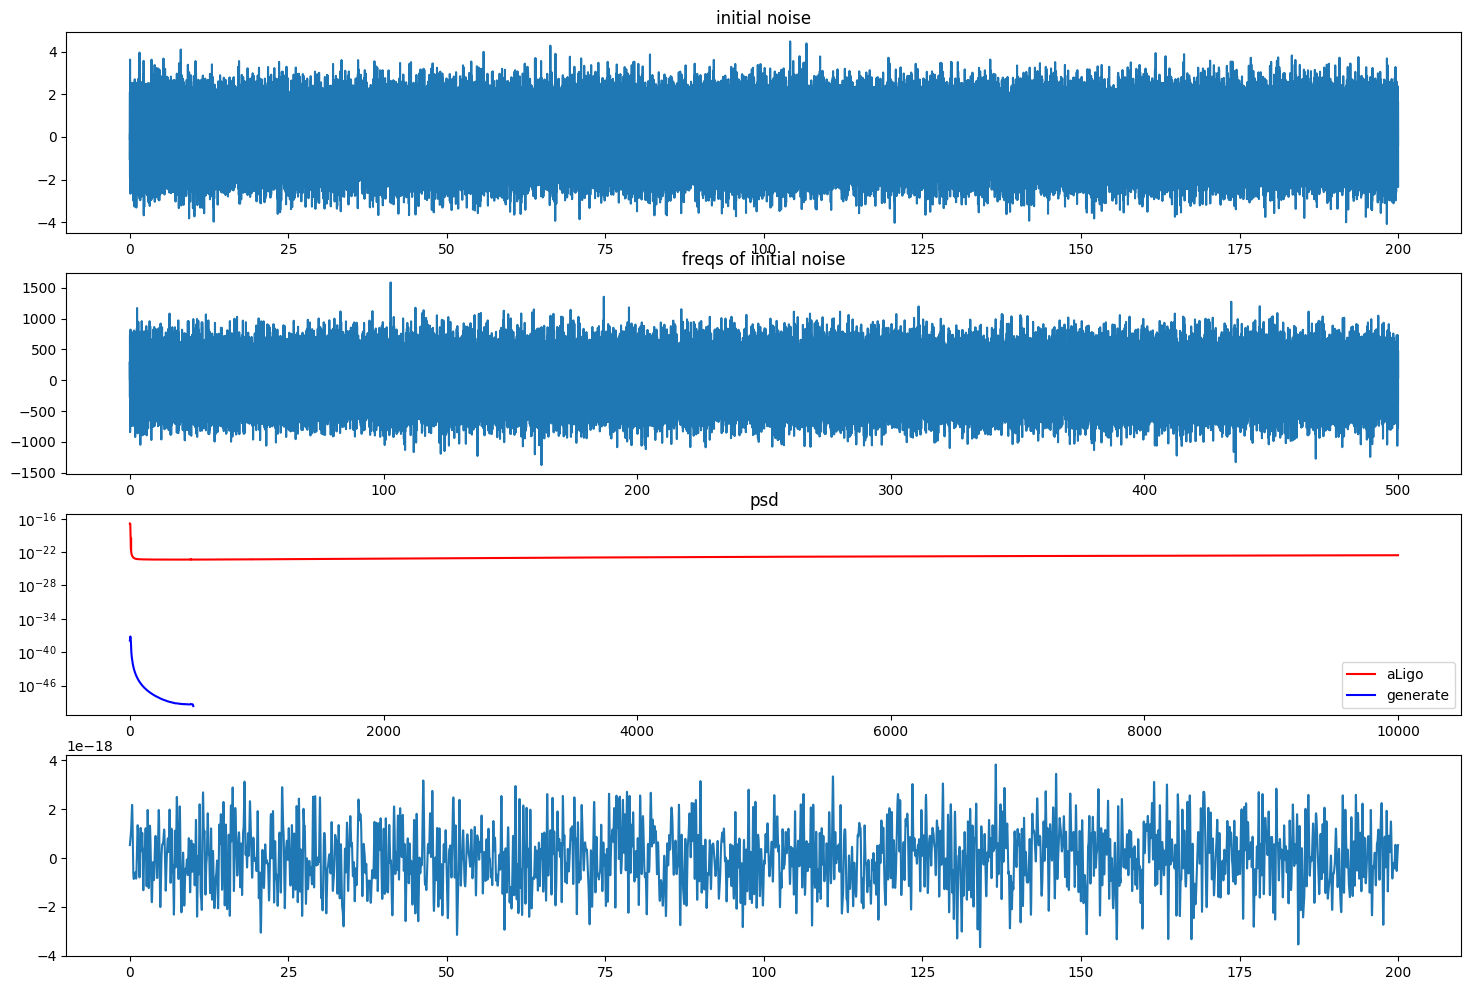

In [5]:

nsamples = 200000
# nsamples = t * samples
timeVec =np.linspace(0,200,nsamples)
tlen = timeVec[-1] - timeVec[0]
samples = nsamples / tlen
# 生成初始噪声
initial_noise = np.random.normal(0,1,nsamples)
# 进行傅里叶变换
initial_noise_fft = np.fft.rfft(initial_noise)
# 获取噪声频率
initial_noise_freq = np.fft.rfftfreq(len(initial_noise),timeVec[1] - timeVec[0])


# 改变PSD
output_noise_fft = initial_noise_fft * PSD_ligo_map(initial_noise_freq)
# 逆傅里叶变换为时域
output_noise = np.fft.irfft(output_noise_fft)

f,pxx = welch(output_noise,fs=samples)

fig = plt.figure(figsize=(18,12))
plt.subplot(4,1,1)
plt.plot(timeVec,initial_noise)
plt.title("initial noise")

plt.subplot(4,1,2)
plt.plot(initial_noise_freq,initial_noise_fft)
plt.title("freqs of initial noise")


plt.subplot(4,1,3)
plt.plot(freqs_ligo,psd_ligo,'r',label = 'aLigo')
plt.plot(f,pxx,'b',label = 'generate')
plt.legend()
plt.yscale('log')
plt.title('psd')

plt.subplot(4,1,4)
plt.plot(timeVec,output_noise)
plt.show()



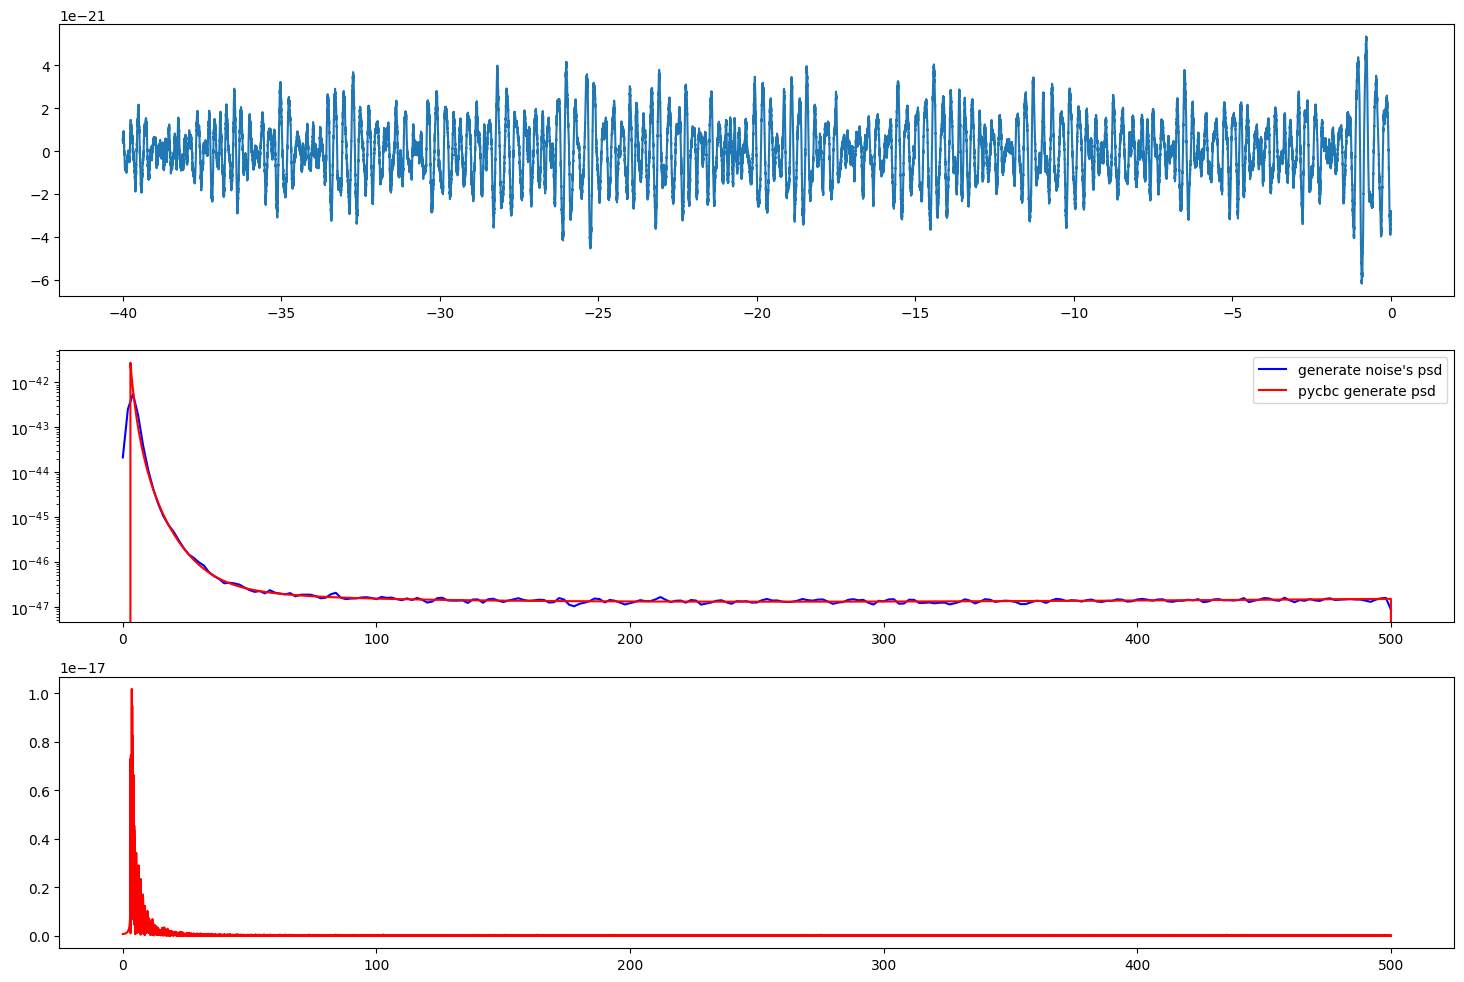

In [3]:
import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
import numpy as np
from scipy.signal import welch

# psd 参数
flow = 3 # 最低频率为3Hz
delta_f = 1.0 / 40 # 频率分辨率
nyq_freq = 500
flen = int(nyq_freq / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen,delta_f,flow)
# 噪声参数
delta_t = 1.0 / 1000  
tsamples = 40000
t = np.arange(-40,0,0.001)
duration = tsamples * delta_t
samples = tsamples / duration

outNoise = pycbc.noise.noise_from_psd(tsamples,delta_t,psd,seed= 123)
freqs = np.fft.rfftfreq(len(outNoise),t[1]-t[0])

f,pxx = welch(outNoise,fs = samples,nperseg=samples/2)
f_noise = np.fft.rfft(outNoise)
plt.figure(figsize=(18,12))
plt.subplot(311)
plt.plot(t,outNoise)

plt.subplot(312)
plt.plot(f,pxx,'b',label = "generate noise's psd")
plt.plot(freqs,psd,'r',label = "pycbc generate psd")
plt.yscale('log')
plt.legend()
# plt.xscale('log')
plt.subplot(313)
plt.plot(freqs,np.abs(f_noise),'r')
plt.show()

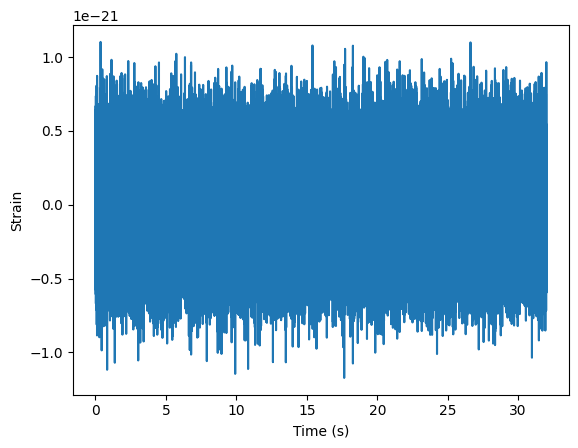

In [2]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide
flow = 30.0
delta_f = 1.0 / 16
flen = int(2048 / delta_f) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)
# Generate 32 seconds of noise at 4096 Hz
delta_t = 1.0 / 4096
tsamples = int(32 / delta_t)
ts = pycbc.noise.noise_from_psd(tsamples, delta_t, psd, seed=127) 

pp.plot(ts.sample_times, ts)
pp.ylabel('Strain')
pp.xlabel('Time (s)')
pp.show()

In [2]:
import lal
import numpy
seed = numpy.random.randint(2**32)

randomness = lal.gsl_rng("ranlux", seed)
random_number = randomness.uniform()  # 生成一个 [0, 1) 范围内的均匀分布随机数
print("生成的随机数:", random_number)

生成的随机数: 0.9696789979934692


In [1]:
import numpy as np
load_array = np.load('PSO_change/PSO_python_demo-main/output_results.npy',allow_pickle=True)

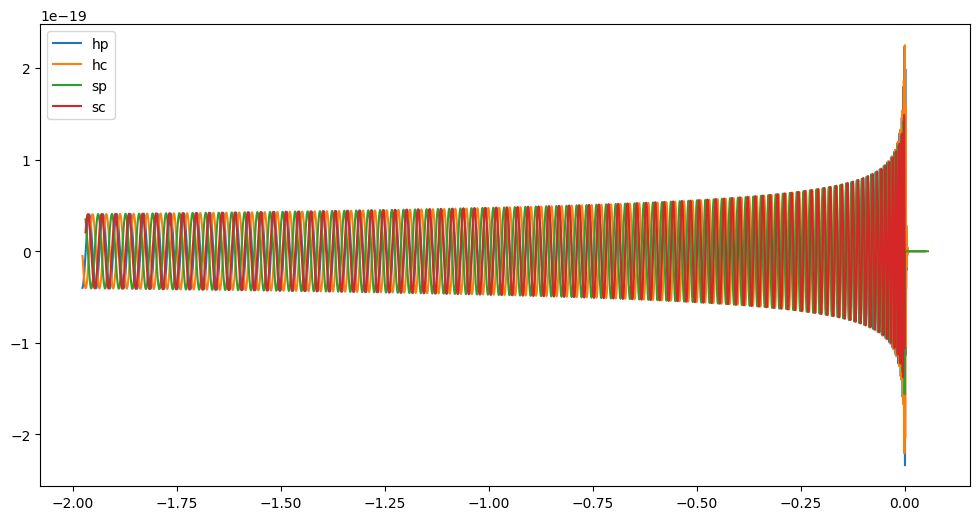

The match is: 0.9534


In [9]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import matplotlib.pyplot as plt

f_low = 30
sample_rate = 4096

# Generate the two waveforms to compare
hp, hc = get_td_waveform(approximant="EOBNRv2",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

sp, sc = get_td_waveform(approximant="TaylorT4",
                         mass1=10,
                         mass2=10,
                         f_lower=f_low,
                         delta_t=1.0/sample_rate)

# Resize the waveforms to the same length
tlen = max(len(sp), len(hp))
sp.resize(tlen)
hp.resize(tlen)

# Generate the aLIGO ZDHP PSD
delta_f = 1.0 / sp.duration
flen = tlen//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, f_low)

# Note: This takes a while the first time as an FFT plan is generated
# subsequent calls are much faster.
m, i = match(hp, sp, psd=psd, low_frequency_cutoff=f_low)
plt.figure(figsize=(12,6))
plt.plot(hp.sample_times,hp,label = 'hp')
plt.plot(hc.sample_times,hc,label = 'hc')
plt.plot(sp.sample_times,sp,label = 'sp')
plt.plot(sc.sample_times,sc,label = 'sc')
plt.legend()
plt.show()
print('The match is: {:.4f}'.format(m))


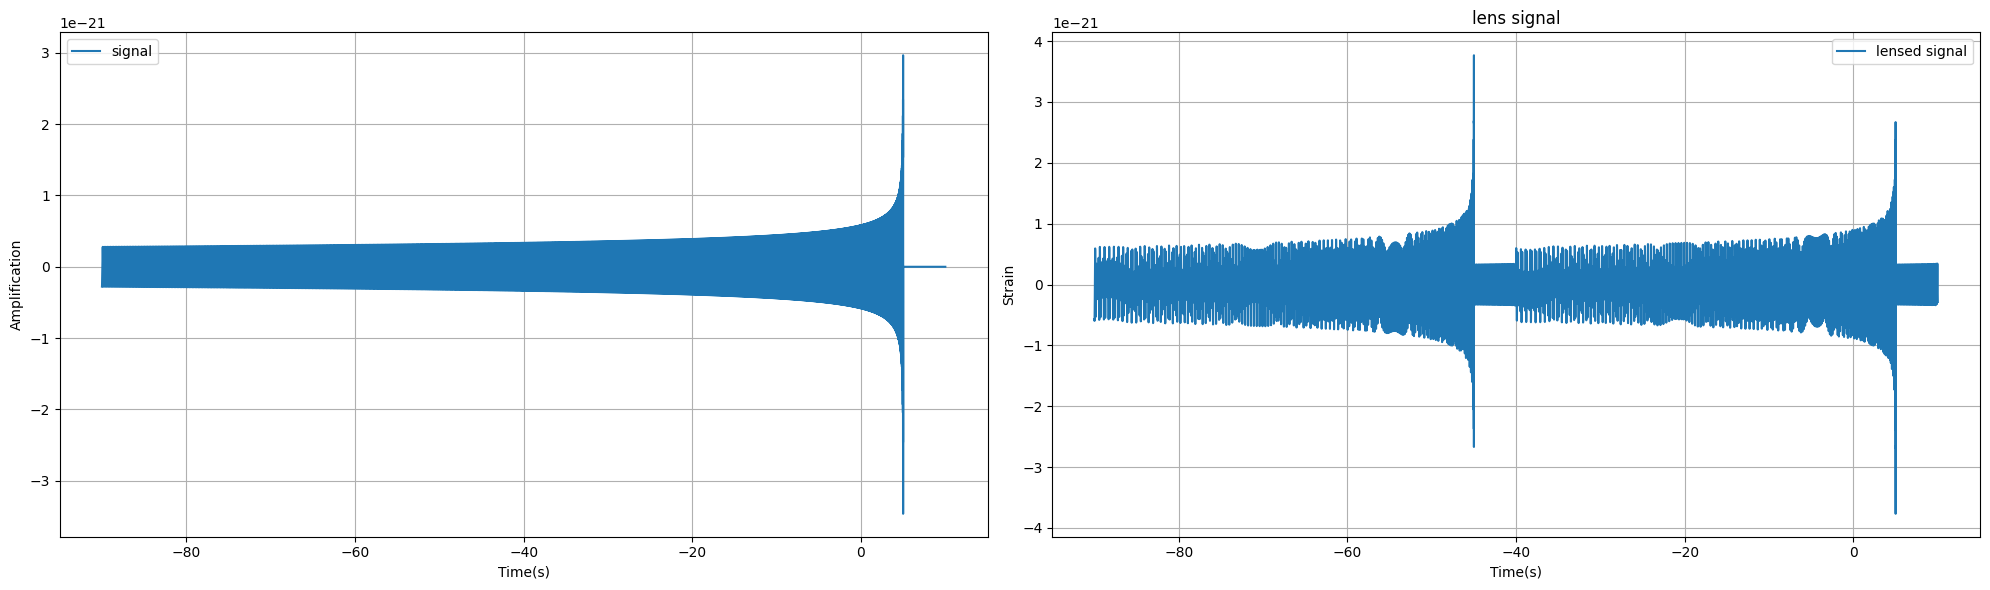

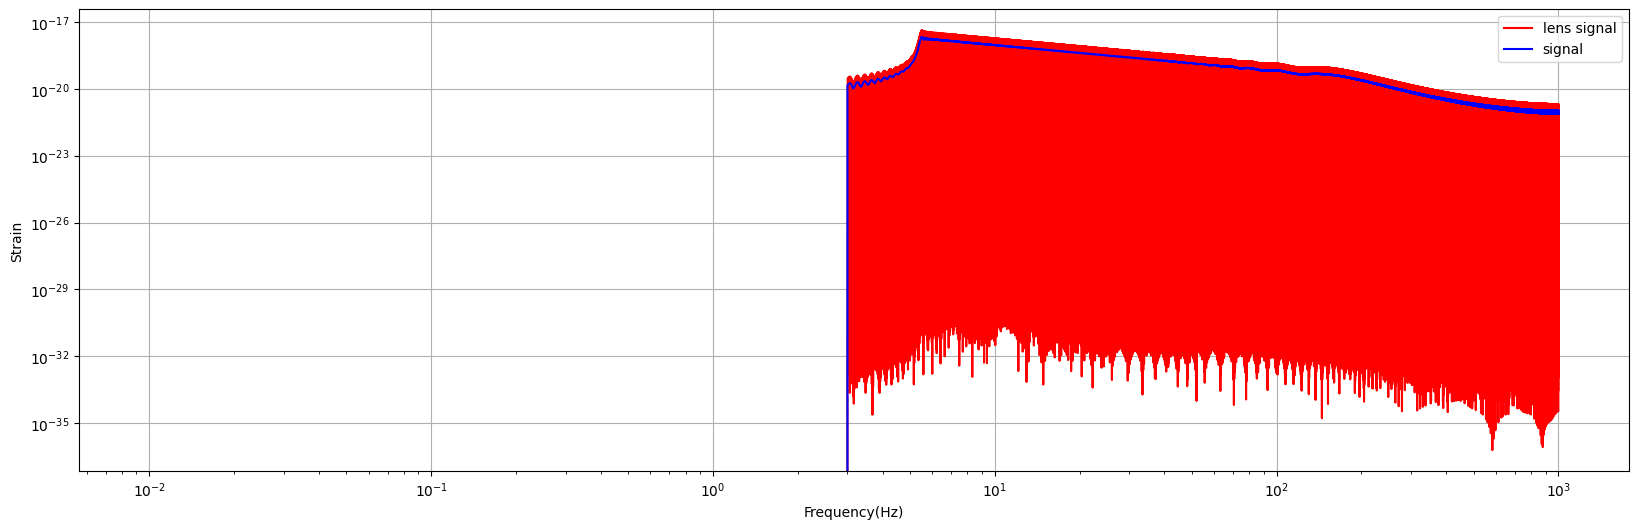